In [1]:
from data_loader import load_json_data
from loc_access import LocDataAccess
from similarity_search import perform_similarity_search, find_similar_passengers, parse_xml
from locationSimilarity import haversine, location_similarity_score, location_matching, address_str_similarity_score
from ageSimilarity import age_similarity_score, calculate_age

from sklearn.metrics import confusion_matrix, matthews_corrcoef
from sklearn.metrics import classification_report, roc_auc_score, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

import pandas as pd
import dask.dataframe as dd

import numpy as np
import os
import glob
from collections import defaultdict
from fuzzywuzzy import fuzz
import string
from concurrent.futures import ProcessPoolExecutor
from random import random, choice, choices, randint
from datetime import datetime, timedelta




In [2]:
#XML Parsing
#Only run when no parsed_xml.csv found
xml_dir = "XMLs"
xml_files = glob.glob(os.path.join(xml_dir, '*.xml'))
all_data = pd.DataFrame()
# Parse each XML file and aggregate data
for file_path in xml_files:
    data = parse_xml(file_path)
    all_data = pd.concat([all_data, data], ignore_index=True)

# columns = ['FilePath', 'BookingID', 'Firstname', 'Surname', 'Name', 'Travel Doc Number', 'Place of Issue', 'OriginIATA', 'OriginCity', 'OriginCountry', 'OriginLat', 'OriginLon', 'DestinationIATA', 'DestinationCity', 'DestinationCountry', 'DestinationLat', 'DestinationLon', 'DOB', 'CityName', 'CityLat', 'CityLon', 'Address', 'Country of Address', 'Nationality', 'Sex']
# df = pd.DataFrame(all_data, columns=columns)
all_data.to_csv('parsed_xml.csv')

In [2]:
airport_data_access = LocDataAccess.get_instance()  # Access the singleton instance
df = pd.read_csv('parsed_xml.csv')
geocrosswalk = pd.read_csv('data/geoCrosswalk/GeoCrossWalkMed.csv')

## Sklearn String Distance

In [3]:
# columns = ['FilePath', 'BookingID', 'Firstname', 'Surname', 'Name', 'OriginIATA', 'OriginLat', 'OriginLon', 'DestinationIATA', 'DestinationLat', 'DestinationLon', 'DOB', 'CityName', 'CityLat', 'CityLon', 'Nationality', 'Sex']
#Query
Firstname = 'Jamie'
Surname = 'Smooth'
name_comb = Firstname + ' ' + Surname
OriginIATA = 'DXB'
DestinationIATA = 'AMS' 
DOB_q = '1973-05-22'
CityName = 'DUBAI'
Nationality = 'PYF'
Sex = 'M'
Address = '41658 Mckinney Ridges Apartment no. 270 Shawmouth, Wyoming 27446'
query = Firstname + ' ' + Surname + ' ' + OriginIATA + ' ' + DestinationIATA + ' ' + DOB_q + ' ' + CityName + ' ' + Nationality + ' ' + Sex

lon_o, lat_o = airport_data_access.get_airport_lon_lat_by_iata(OriginIATA)
lon_d, lat_d = airport_data_access.get_airport_lon_lat_by_iata(DestinationIATA)
lon_c, lat_c = airport_data_access.get_airport_lon_lat_by_city(CityName)
country = airport_data_access.get_country_by_city(CityName)
ctry_org = airport_data_access.get_country_by_airport_iata(OriginIATA)
ctry_dest = airport_data_access.get_country_by_airport_iata(DestinationIATA)
city_org = airport_data_access.get_city_by_airport_iata(OriginIATA)
city_dest = airport_data_access.get_city_by_airport_iata(DestinationIATA)

In [4]:
#Calculate counts for each columns
gender_counts = df['Sex'].value_counts(normalize=True).to_dict()
origin_airport_counts = df['OriginIATA'].value_counts(normalize=True).to_dict()
origin_city_counts = df['OriginCity'].value_counts(normalize=True).to_dict()
origin_country_counts = df['OriginCountry'].value_counts(normalize=True).to_dict()
destination_airport_counts = df['DestinationIATA'].value_counts(normalize=True).to_dict()
destination_city_counts = df['DestinationCity'].value_counts(normalize=True).to_dict()
destination_country_counts = df['DestinationCountry'].value_counts(normalize=True).to_dict()
city_address_counts = df['CityName'].value_counts(normalize=True).to_dict()
country_address_counts = df['Country of Address'].value_counts(normalize=True).to_dict()
nationality_counts = df['Nationality'].value_counts(normalize=True).to_dict()
DOB_counts = df['DOB'].value_counts(normalize=True).to_dict()
firstname_counts = df['Firstname'].value_counts(normalize=True).to_dict()
surname_counts = df['Surname'].value_counts(normalize=True).to_dict()



In [5]:
gender_counts = df['Sex'].str.lower().value_counts(normalize=True)
origin_airport_counts = df['OriginIATA'].str.lower().value_counts(normalize=True)
origin_city_counts = df['OriginCity'].str.lower().value_counts(normalize=True)
origin_country_counts = df['OriginCountry'].str.lower().value_counts(normalize=True)
destination_airport_counts = df['DestinationIATA'].str.lower().value_counts(normalize=True)
destination_city_counts = df['DestinationCity'].str.lower().value_counts(normalize=True)
destination_country_counts = df['DestinationCountry'].str.lower().value_counts(normalize=True)
city_address_counts = df['CityName'].str.lower().value_counts(normalize=True)
country_address_counts = df['Country of Address'].str.lower().value_counts(normalize=True)
nationality_counts = df['Nationality'].str.lower().value_counts(normalize=True)
DOB_counts = df['DOB'].value_counts(normalize=True)
firstname_counts = df['Firstname'].str.lower().value_counts(normalize=True)
surname_counts = df['Surname'].str.lower().value_counts(normalize=True)

In [7]:
origin_airport_counts

OriginIATA
dxb    0.678109
mad    0.112976
lhr    0.044832
cph    0.043935
fco    0.041629
arn    0.040733
svo    0.037787
Name: proportion, dtype: float64

In [6]:
def count_likelihood2(type, counter, num_records):
    # Ensure data_count is a dictionary
    # if not isinstance(counter, dict):
    #     raise ValueError("data_count must be a dictionary.")

    # Get the likelihood of 'type', defaulting to 0 if not found
    type_ll = counter.get(type, 0)
    prob1 = float('inf') if type_ll == 0 else 1 / (type_ll * num_records)

    try:
        # Handle division by zero if 'type' is not found or has a count of 0
        if type_ll == 0:
            raise ValueError(f"The specified type '{type}' was not found or has zero occurrences in the data.")
        return pd.Series([type_ll, prob1])
    except ZeroDivisionError:
        print("Division by zero encountered. This is likely due to the specified type not being present in the data or having zero occurrences.")
        return pd.Series([None, None])
    except Exception as e:
        # Handle any other unexpected errors
        print(f"An unexpected error occurred: {e}")
        return pd.Series([None, None])

In [7]:
def count_likelihood(type, df_col, df):
    # Check if df_col is a valid column in the DataFrame
    if df_col not in df.columns:
        raise ValueError(f"Column '{df_col}' does not exist in the DataFrame.")
    
    # Ensure 'type' is a hashable and comparable type, can add more checks if needed
    if not isinstance(type, (str, int, float)):
        raise ValueError("Type must be a string, integer, or float.")
    
    try:
        # Calculate the normalized count (likelihood) of the type in the specified DataFrame column
        counter = df[df_col].value_counts(normalize=True)
        type_ll = counter.get(type, 0)  # Get the likelihood of 'type', default to 0 if not found

        # Handle division by zero if 'type' is not found or has a count of 0
        if type_ll == 0:
            raise ValueError(f"The specified type '{type}' was not found or has zero occurrences in the column '{df_col}'.")
        
        return 1/type_ll
    except ZeroDivisionError:
        print("Division by zero encountered. This is likely due to the specified type not being present in the DataFrame column.")
        return None
    except Exception as e:
        # Handle any other unexpected errors
        print(f"An unexpected error occurred: {e}")
        return None
    
    try:
        prob1 = float('inf') if type_ll == 0 else 1 / (type_ll * num_records)
    except ZeroDivisionError:
        prob1 = float('inf')  # Assign infinity if division by zero occurs
    except Exception as e:
        print(f"Error during probability calculation: {e}")
        prob1 = prob2 = None


In [8]:
#For firstnames and surnames
from fuzzywuzzy import fuzz
import pandas as pd

def string_similarity(string1, string2, string_counts, num_records):
    # Ensure input strings are valid
    if not isinstance(string1, str) or not isinstance(string2, str):
        raise ValueError("Both string1 and string2 must be valid strings.")
    
    # Ensure string_counts is accessible and num_records is valid
    # if not isinstance(string_counts, dict):
    #     raise ValueError("string_counts must be a dictionary.")
    if not isinstance(num_records, int) or num_records <= 0:
        raise ValueError("num_records must be a positive integer.")
    
    # Calculate string similarity
    try:
        str_similarity = fuzz.ratio(string1.lower(), string2.lower())
    except Exception as e:
        print(f"Error calculating string similarity: {e}")
        return None, None, None
    
    # Initialize default values for inverse likelihoods
    str1_ll_inverse = str2_ll_inverse = None
    # Attempt to calculate likelihoods, handling division by zero
    try:
        str1_ll = string_counts.get(string1.lower(), 0)
        str2_ll = string_counts.get(string2.lower(), 0)
        
        str1_ll_inverse = float('inf') if str1_ll == 0 else 1 / str1_ll
        str2_ll_inverse = float('inf') if str2_ll == 0 else 1 / str2_ll
    except ZeroDivisionError:
        print("Division by zero encountered in likelihood calculation.")
    except Exception as e:
        print(f"Error during likelihood calculation: {e}")
    
    # Calculate probabilities, handling division by zero explicitly
    try:
        prob1 = float('inf') if str1_ll == 0 else 1 / (str1_ll * num_records)
        prob2 = float('inf') if str2_ll == 0 else 1 / (str2_ll * num_records)
    except ZeroDivisionError:
        prob1 = prob2 = float('inf')  # Assign infinity if division by zero occurs
    except Exception as e:
        print(f"Error during probability calculation: {e}")
        prob1 = prob2 = None
    
    return pd.Series([str_similarity, string1, string2, str1_ll, str2_ll, prob1, prob2])


## Similarity Checking

In [9]:
similarity_df = pd.DataFrame()
num_records = df.shape[0]
max_distance = 20000
#Name Similarity

similarity_df[['FNSimilarity', 'FN1', 'FN2', 'FN_rarity1', 'FN_rarity2', 'FN_prob1', 'FN_prob2']] = df['Firstname'].str.lower().apply(lambda x: string_similarity(Firstname.lower(), x, firstname_counts, num_records))
similarity_df[['SNSimilarity', 'SN1', 'SN2', 'SN_rarity1', 'SN_rarity2', 'SN_prob1', 'SN_prob2']] = df['Surname'].str.lower().apply(lambda x: string_similarity(Surname.lower(), x, surname_counts, num_records))
similarity_df[['DOBSimilarity', 'DOB1', 'DOB2', 'DOB_rarity1', 'DOB_rarity2', 'DOB_prob1', 'DOB_prob2']] = df['DOB'].str.lower().apply(lambda x: string_similarity(DOB_q.lower(), x, DOB_counts, num_records))
similarity_df['AgeSimilarity']= df['DOB'].apply(lambda x: age_similarity_score(DOB_q, x))
similarity_df[['strAddressSimilarity', 'jcdAddressSimilarity']] = df['Address'].apply(lambda x: address_str_similarity_score(Address, x))
similarity_df['cityAddressMatch'] = df['CityName'].apply(lambda x: location_matching(CityName, x))
similarity_df[['cityAddressRarity1', 'cityAddressProb1']] = count_likelihood2(CityName.lower(), city_address_counts, num_records)
similarity_df[['cityAddressRarity2', 'cityAddressProb2']] = df['CityName'].str.lower().apply(lambda x: count_likelihood2(x, city_address_counts, num_records))
similarity_df['countryAddressMatch'] = df['Country of Address'].apply(lambda x: location_matching(country.lower(), x))
similarity_df[['countryAddressRarity1', 'countryAddressProb1']] = count_likelihood2(country.lower(), country_address_counts, num_records)
similarity_df[['countryAddressRarity2', 'countryAddressProb2']] = df['Country of Address'].str.lower().apply(lambda x: count_likelihood2(x, country_address_counts, num_records))
similarity_df['sexMatch'] = df['Sex'].str.lower().apply(lambda x: location_matching(Sex.lower(), x))
similarity_df[['sexRarity1', 'sexProb1']] = count_likelihood2(Sex.lower(), gender_counts, num_records)
similarity_df[['sexRarity2', 'sexProb2']] = df['Sex'].str.lower().apply(lambda x: count_likelihood2(x, gender_counts, num_records))
similarity_df['natMatch'] = df['Nationality'].str.lower().apply(lambda x: location_matching(Nationality.lower(), x))
similarity_df[['natRarity1', 'natProb1']] = count_likelihood2(Nationality.lower(), nationality_counts, num_records)
similarity_df[['natRarity2', 'natProb2']] = df['Nationality'].str.lower().apply(lambda x: count_likelihood2(x, nationality_counts, num_records))
similarity_df['originAirportMatch'] = df['OriginIATA'].str.lower().apply(lambda x: location_matching(OriginIATA.lower(), x))
similarity_df[['originAirportRarity1', 'originAirportProb1']] = count_likelihood2(OriginIATA.lower(), origin_airport_counts, num_records)
similarity_df[['originAirportRarity2', 'originAirportProb2']] = df['OriginIATA'].str.lower().apply(lambda x: count_likelihood2(x, origin_airport_counts, num_records))
similarity_df['destinationAirportMatch'] = df['DestinationIATA'].str.lower().apply(lambda x: location_matching(DestinationIATA.lower(), x))
similarity_df[['destinationAirportRarity1', 'destinationAirportProb1']] = count_likelihood2(OriginIATA.lower(), origin_airport_counts, num_records)
similarity_df[['destinationAirportRarity2', 'destinationAirportProb2']] = df['DestinationIATA'].str.lower().apply(lambda x: count_likelihood2(x, destination_airport_counts, num_records))
similarity_df['originCityMatch'] = df['OriginCity'].str.lower().apply(lambda x: location_matching(city_org.lower(), x))
similarity_df[['originCityRarity1', 'originCityProb1']] = count_likelihood2(city_org.lower(), origin_city_counts, num_records)
similarity_df[['originCityRarity2', 'originCityProb2']] = df['OriginCity'].str.lower().apply(lambda x: count_likelihood2(x, origin_city_counts, num_records))
similarity_df['destinationCityMatch'] = df['DestinationCity'].str.lower().apply(lambda x: location_matching(city_dest.lower(), x))
similarity_df[['destinationCityRarity1', 'destinationCityProb1']] = count_likelihood2(city_dest.lower(), destination_city_counts, num_records)
similarity_df[['destinationCityRarity2', 'destinationCityProb2']] = df['DestinationCity'].str.lower().apply(lambda x: count_likelihood2(x, destination_city_counts, num_records))
similarity_df['originCountryMatch'] = df['OriginCountry'].str.lower().apply(lambda x: location_matching(ctry_org.lower(), x))
similarity_df[['originCountryRarity1', 'originCountryProb1']] = count_likelihood2(ctry_org.lower(), origin_country_counts, num_records)
similarity_df[['originCountryRarity2', 'originCountryProb2']] = df['OriginCountry'].str.lower().apply(lambda x: count_likelihood2(x, origin_country_counts, num_records))
similarity_df['destinationCountryMatch'] = df['DestinationCountry'].str.lower().apply(lambda x: location_matching(ctry_dest.lower(), x))
similarity_df[['destinationCountryRarity1', 'destinationCountryProb1']] = count_likelihood2(ctry_dest.lower(), destination_country_counts, num_records)
similarity_df[['destinationCountryRarity2', 'destinationCountryProb2']] = df['DestinationCountry'].str.lower().apply(lambda x: count_likelihood2(x, destination_country_counts, num_records))
similarity_df[['originSimilarity', 'originExpScore']] = df.apply(lambda row: location_similarity_score(lon_o, lat_o, row['OriginLon'], row['OriginLat'], max_distance), axis=1, result_type='expand')
similarity_df[['destinationSimilarity', 'destinationExpScore']] = df.apply(lambda row: location_similarity_score(lon_d, lat_d, row['DestinationLon'], row['DestinationLat'], max_distance), axis=1, result_type='expand')





## Obstructors

In [10]:
def introduce_dob_typos(dob, typo_rate):
    dob_parts = dob.split("-")
    old_dob = dob
    year = dob_parts[0]
    month = dob_parts[1]
    day = dob_parts[2]
    
    if random() < typo_rate:
        year = list(year)
        digit_to_change = randint(0, len(year) - 1)
        year[digit_to_change] = str(randint(0, 9))
        year = "".join(year)

    if random() < typo_rate:
        month = list(month)
        digit_to_change = randint(0, len(month) - 1)
        month[digit_to_change] = str(randint(0, 1))
        month = "".join(month)

    if random() < typo_rate:
        day = list(day)
        digit_to_change = randint(0, len(day) - 1)
        day[digit_to_change] = str(randint(0, 3))
        day = "".join(day)
        
    try:
        new_date = datetime(int(year), int(month), int(day))
    except ValueError:
        # Invalid date, correct it to a valid date
        year = dob_parts[0]
        month = dob_parts[1]
        day = dob_parts[2]
    if  (int(year) > 2100 or int(year) < 1900):
        year = dob_parts[0]

    return f"{year}-{month}-{day}"

In [11]:
def introduce_typos(text, typo_rate):
    """Introduces a diverse set of typos into a given text based on the specified typo rate.
    
    Args:
        text (str): The input text where typos will be introduced.
        typo_rate (float): The probability of introducing a typo at each character position.
    
    Returns:
        str: The text with introduced typos.
    """
    typo_text = list(text)
    operations = ['delete', 'insert', 'substitute', 'swap']
    for i in range(len(typo_text)):
        if random() < typo_rate:
            operation = choice(operations)
            if operation == 'delete':
                # Delete the character at the current position
                typo_text[i] = ''
            elif operation == 'insert':
                # Insert a random character at the current position
                typo_text[i] = typo_text[i] + choice(string.ascii_letters)
            elif operation == 'substitute':
                # Substitute the character at the current position with a random character
                typo_text[i] = choice(string.ascii_letters)
            elif operation == 'swap' and i < len(typo_text) - 1:
                # Swap the character with the next character
                typo_text[i], typo_text[i + 1] = typo_text[i + 1], typo_text[i]
    
    # Filter out empty strings resulting from deletions and join the list back into a string
    return ''.join(filter(None, typo_text))

In [12]:
def introduce_error_airport(row, airport_column, airports_df, replacement_preference, error_rate):
    # Generate a random number between 0 and 1 to compare with the error rate
    if random() > error_rate:
        # If the generated number is greater than the error rate, don't introduce an error
        return row[airport_column]
    
    current_airport = row[airport_column]
    city, country = airports_df[airports_df['IATA'] == current_airport][['City', 'HH_ISO']].iloc[0]
    
    if replacement_preference == 'city':
        city_airports = airports_df[(airports_df['City'] == city) & (airports_df['IATA'] != current_airport)]
        if not city_airports.empty:
            return np.random.choice(city_airports['IATA'].values)
    
    if replacement_preference in ['city', 'country']:
        country_airports = airports_df[(airports_df['HH_ISO'] == country) & (airports_df['IATA'] != current_airport)]
        if not country_airports.empty:
            return np.random.choice(country_airports['IATA'].values)
    
    return np.random.choice(airports_df[airports_df['IATA'] != current_airport]['IATA'].values)

In [13]:
def introduce_error_nat_city(row, geocrosswalk, column_df, column_geo, error_rate):
    if random() > error_rate:
        return row[column_df]
    
    new_value = choice(geocrosswalk[column_geo].unique())
    row[column_df] = new_value
    return new_value

In [14]:
def introduce_error_sex(row, error_rate):
    if random() > error_rate:
        return row['Sex']
    
    new_value = choice(['M', 'F'])
    row['Sex'] = new_value
    return new_value

In [15]:
def update_loc_airport(row, changed_col):
    lon, lat = airport_data_access.get_airport_lon_lat_by_iata(row[changed_col])
    city = airport_data_access.get_city_by_airport_iata(row[changed_col])
    country = airport_data_access.get_country_by_airport_iata(row[changed_col])
    return pd.Series([lat, lon, city, country])

### Obstruct 1

In [19]:
df_obstruct1 = df.head(10).copy()
rate = 0.2
rate_typos = 0.1
df_obstruct1['Sex'] = df_obstruct1.apply(introduce_error_sex, args = (rate, ), axis = 1)
df_obstruct1['Firstname'] = df_obstruct1['Firstname'].apply(lambda x: introduce_typos(x, rate_typos))
df_obstruct1['Surname'] = df_obstruct1['Surname'].apply(lambda x: introduce_typos(x, rate_typos))
df_obstruct1['Address'] = df_obstruct1['Address'].apply(lambda x: introduce_typos(x, rate_typos))
df_obstruct1['DOB'] = df_obstruct1['DOB'].apply(lambda x: introduce_dob_typos(x, rate_typos))
df_obstruct1['OriginIATA'] = df_obstruct1.apply(lambda row: introduce_error_airport(row, 'OriginIATA', geocrosswalk, 'city', rate), axis=1)
df_obstruct1['DestinationIATA'] = df_obstruct1.apply(lambda row: introduce_error_airport(row, 'DestinationIATA', geocrosswalk, 'city', rate), axis=1)
df_obstruct1['Nationality'] = df_obstruct1.apply(introduce_error_nat_city, args = (geocrosswalk, 'Nationality', 'HH_ISO', rate), axis = 1)
df_obstruct1['CityName'] = df_obstruct1.apply(introduce_error_nat_city, args = (geocrosswalk, 'CityName', 'City', rate), axis = 1)
df_obstruct1[['OriginLat', 'OriginLon', 'OriginCity', 'OriginCountry']] = df_obstruct1.apply(update_loc_airport, args = ('OriginIATA', ), axis = 1)
df_obstruct1[['DestinationLat', 'DestinationLon', 'DestinationCity', 'DestinationCountry']] = df_obstruct1.apply(update_loc_airport, args = ('DestinationIATA', ), axis = 1)





In [20]:
df_obstruct2 = df.head(10).copy()
rate = 0.4
rate_typos = 0.2
df_obstruct2['Sex'] = df_obstruct2.apply(introduce_error_sex, args = (rate, ), axis = 1)
df_obstruct2['Firstname'] = df_obstruct2['Firstname'].apply(lambda x: introduce_typos(x, rate))
df_obstruct2['Surname'] = df_obstruct2['Surname'].apply(lambda x: introduce_typos(x, rate))
df_obstruct2['Address'] = df_obstruct2['Address'].apply(lambda x: introduce_typos(x, rate))
df_obstruct2['DOB'] = df_obstruct2['DOB'].apply(lambda x: introduce_dob_typos(x, rate))
df_obstruct2['OriginIATA'] = df_obstruct2.apply(lambda row: introduce_error_airport(row, 'OriginIATA', geocrosswalk, 'city', rate), axis=1)
df_obstruct2['DestinationIATA'] = df_obstruct2.apply(lambda row: introduce_error_airport(row, 'DestinationIATA', geocrosswalk, 'city', rate), axis=1)
df_obstruct2['Nationality'] = df_obstruct2.apply(introduce_error_nat_city, args = (geocrosswalk, 'Nationality', 'HH_ISO', rate), axis = 1)
df_obstruct2['CityName'] = df_obstruct2.apply(introduce_error_nat_city, args = (geocrosswalk, 'CityName', 'City', rate), axis = 1)
df_obstruct2[['OriginLat', 'OriginLon', 'OriginCity', 'OriginCountry']] = df_obstruct2.apply(update_loc_airport, args = ('OriginIATA', ), axis = 1)
df_obstruct2[['DestinationLat', 'DestinationLon', 'DestinationCity', 'DestinationCountry']] = df_obstruct2.apply(update_loc_airport, args = ('DestinationIATA', ), axis = 1)

In [21]:
df_obstruct3 = df.head(10).copy()
rate = 0.6
rate_typos = 0.3
df_obstruct3['Sex'] = df_obstruct3.apply(introduce_error_sex, args = (rate, ), axis = 1)
df_obstruct3['Firstname'] = df_obstruct3['Firstname'].apply(lambda x: introduce_typos(x, rate))
df_obstruct3['Surname'] = df_obstruct3['Surname'].apply(lambda x: introduce_typos(x, rate))
df_obstruct3['Address'] = df_obstruct3['Address'].apply(lambda x: introduce_typos(x, rate))
df_obstruct3['DOB'] = df_obstruct3['DOB'].apply(lambda x: introduce_dob_typos(x, rate))
df_obstruct3['OriginIATA'] = df_obstruct3.apply(lambda row: introduce_error_airport(row, 'OriginIATA', geocrosswalk, 'city', rate), axis=1)
df_obstruct3['DestinationIATA'] = df_obstruct3.apply(lambda row: introduce_error_airport(row, 'DestinationIATA', geocrosswalk, 'city', rate), axis=1)
df_obstruct3['Nationality'] = df_obstruct3.apply(introduce_error_nat_city, args = (geocrosswalk, 'Nationality', 'HH_ISO', rate), axis = 1)
df_obstruct3['CityName'] = df_obstruct3.apply(introduce_error_nat_city, args = (geocrosswalk, 'CityName', 'City', rate), axis = 1)
df_obstruct3[['OriginLat', 'OriginLon', 'OriginCity', 'OriginCountry']] = df_obstruct3.apply(update_loc_airport, args = ('OriginIATA', ), axis = 1)
df_obstruct3[['DestinationLat', 'DestinationLon', 'DestinationCity', 'DestinationCountry']] = df_obstruct3.apply(update_loc_airport, args = ('DestinationIATA', ), axis = 1)

In [44]:
df_true = df.head(10).copy()
df_true['Mark'] = 'Original'
df_obstruct1['Mark'] = 'Obs1'
df_obstruct2['Mark'] = 'Obs2'
df_obstruct3['Mark'] = 'Obs3'

df_appended = pd.concat([df_true, df_obstruct1], axis=0).reset_index(drop=True)
df_appended = pd.concat([df_appended, df_obstruct2], axis=0).reset_index(drop=True)
df_appended = pd.concat([df_appended, df_obstruct3], axis=0).reset_index(drop=True)
df_appended.shape

df_appended1 = df_appended.copy()
df_appended1['key'] = 1

ddf_ap1 = dd.from_pandas(df_appended1, npartitions=50)
ddf_ap2 = dd.from_pandas(df_appended1, npartitions=50)


In [35]:
df_appended.to_csv('appended_df_short.csv')

In [24]:
df_appended.shape

(40, 27)

In [45]:
cartesian_ddf = dd.merge(ddf_ap1, ddf_ap2, on='key').drop('key', axis=1)
cartesian_df = cartesian_ddf.compute()

In [66]:
cartesian_similarity_df = pd.DataFrame()
num_records = df_appended.shape[0]
max_distance = 20000

gender_counts = df_appended['Sex'].str.lower().value_counts(normalize=True)
origin_airport_counts = df_appended['OriginIATA'].str.lower().value_counts(normalize=True)
origin_city_counts = df_appended['OriginCity'].str.lower().value_counts(normalize=True)
origin_country_counts = df_appended['OriginCountry'].str.lower().value_counts(normalize=True)
destination_airport_counts = df_appended['DestinationIATA'].str.lower().value_counts(normalize=True)
destination_city_counts = df_appended['DestinationCity'].str.lower().value_counts(normalize=True)
destination_country_counts = df_appended['DestinationCountry'].str.lower().value_counts(normalize=True)
city_address_counts = df_appended['CityName'].str.lower().value_counts(normalize=True)
country_address_counts = df_appended['Country of Address'].str.lower().value_counts(normalize=True)
nationality_counts = df_appended['Nationality'].str.lower().value_counts(normalize=True)
DOB_counts = df_appended['DOB'].value_counts(normalize=True)
firstname_counts = df_appended['Firstname'].str.lower().value_counts(normalize=True)
surname_counts = df_appended['Surname'].str.lower().value_counts(normalize=True)


# String similarity for first names
cartesian_similarity_df[['FNSimilarity', 'FN1', 'FN2', 'FN_rarity1', 'FN_rarity2', 'FN_prob1', 'FN_prob2']] = cartesian_df.apply(lambda row: string_similarity(row['Firstname_x'].lower(), row['Firstname_y'].lower(), firstname_counts, num_records), axis=1)

# String similarity for surnames
cartesian_similarity_df[['SNSimilarity', 'SN1', 'SN2', 'SN_rarity1', 'SN_rarity2', 'SN_prob1', 'SN_prob2']] = cartesian_df.apply(lambda row: string_similarity(row['Surname_x'].lower(), row['Surname_y'].lower(), surname_counts, num_records), axis=1)

# String similarity for DOB
cartesian_similarity_df[['DOBSimilarity', 'DOB1', 'DOB2', 'DOB_rarity1', 'DOB_rarity2', 'DOB_prob1', 'DOB_prob2']] = cartesian_df.apply(lambda row: string_similarity(row['DOB_x'].lower(), row['DOB_y'].lower(), DOB_counts, num_records), axis=1)

# Age similarity
cartesian_similarity_df['AgeSimilarity'] = cartesian_df.apply(lambda row: age_similarity_score(row['DOB_x'], row['DOB_y']), axis=1)

# Address similarity 
cartesian_similarity_df[['strAddressSimilarity', 'jcdAddressSimilarity']] = cartesian_df.apply(lambda row: address_str_similarity_score(row['Address_x'], row['Address_y']), axis=1)

# City address match
cartesian_similarity_df['cityAddressMatch'] = cartesian_df.apply(lambda row: location_matching(row['CityName_x'], row['CityName_y']), axis=1)

# City address rarity and probability
cartesian_similarity_df[['cityAddressRarity1', 'cityAddressProb1']] = cartesian_df['CityName_x'].str.lower().apply(lambda x: count_likelihood2(x, city_address_counts, num_records))
cartesian_similarity_df[['cityAddressRarity2', 'cityAddressProb2']] = cartesian_df['CityName_y'].str.lower().apply(lambda x: count_likelihood2(x, city_address_counts, num_records))

# Country address match
cartesian_similarity_df['countryAddressMatch'] = cartesian_df.apply(lambda row: location_matching(row['Country of Address_x'], row['Country of Address_y']), axis=1)

# Country address rarity and probability
cartesian_similarity_df[['countryAddressRarity1', 'countryAddressProb1']] = cartesian_df['Country of Address_x'].str.lower().apply(lambda x: count_likelihood2(x, country_address_counts, num_records))
cartesian_similarity_df[['countryAddressRarity2', 'countryAddressProb2']] = cartesian_df['Country of Address_y'].str.lower().apply(lambda x: count_likelihood2(x, country_address_counts, num_records))

# Sex match and corresponding metrics
cartesian_similarity_df['sexMatch'] = cartesian_df.apply(lambda row: location_matching(row['Sex_x'].lower(), row['Sex_y'].lower()), axis=1)
cartesian_similarity_df[['sexRarity1', 'sexProb1']] = cartesian_df['Sex_x'].str.lower().apply(lambda x: count_likelihood2(x, gender_counts, num_records))
cartesian_similarity_df[['sexRarity2', 'sexProb2']] = cartesian_df['Sex_y'].str.lower().apply(lambda x: count_likelihood2(x, gender_counts, num_records))

# Nationality match and corresponding metrics
cartesian_similarity_df['natMatch'] = cartesian_df.apply(lambda row: location_matching(row['Nationality_x'].lower(), row['Nationality_y'].lower()), axis=1)
cartesian_similarity_df[['natRarity1', 'natProb1']] = cartesian_df['Nationality_x'].str.lower().apply(lambda x: count_likelihood2(x, nationality_counts, num_records))
cartesian_similarity_df[['natRarity2', 'natProb2']] = cartesian_df['Nationality_y'].str.lower().apply(lambda x: count_likelihood2(x, nationality_counts, num_records))

# Origin airport match and corresponding metrics
cartesian_similarity_df['originAirportMatch'] = cartesian_df.apply(lambda row: location_matching(row['OriginIATA_x'].lower(), row['OriginIATA_y'].lower()), axis=1)
cartesian_similarity_df[['originAirportRarity1', 'originAirportProb1']] = cartesian_df['OriginIATA_x'].str.lower().apply(lambda x: count_likelihood2(x, origin_airport_counts, num_records))
cartesian_similarity_df[['originAirportRarity2', 'originAirportProb2']] = cartesian_df['OriginIATA_y'].str.lower().apply(lambda x: count_likelihood2(x, origin_airport_counts, num_records))

# Destination airport match and corresponding metrics
cartesian_similarity_df['destinationAirportMatch'] = cartesian_df.apply(lambda row: location_matching(row['DestinationIATA_x'].lower(), row['DestinationIATA_y'].lower()), axis=1)
cartesian_similarity_df[['destinationAirportRarity1', 'destinationAirportProb1']] = cartesian_df['DestinationIATA_x'].str.lower().apply(lambda x: count_likelihood2(x, destination_airport_counts, num_records))
cartesian_similarity_df[['destinationAirportRarity2', 'destinationAirportProb2']] = cartesian_df['DestinationIATA_y'].str.lower().apply(lambda x: count_likelihood2(x, destination_airport_counts, num_records))

# Origin city match and corresponding metrics
cartesian_similarity_df['originCityMatch'] = cartesian_df.apply(lambda row: location_matching(row['OriginCity_x'].lower(), row['OriginCity_y'].lower()), axis=1)
cartesian_similarity_df[['originCityRarity1', 'originCityProb1']] = cartesian_df['OriginCity_x'].str.lower().apply(lambda x: count_likelihood2(x, origin_city_counts, num_records))
cartesian_similarity_df[['originCityRarity2', 'originCityProb2']] = cartesian_df['OriginCity_y'].str.lower().apply(lambda x: count_likelihood2(x, origin_city_counts, num_records))

# Destination city match and corresponding metrics
cartesian_similarity_df['destinationCityMatch'] = cartesian_df.apply(lambda row: location_matching(row['DestinationCity_x'].lower(), row['DestinationCity_y'].lower()), axis=1)
cartesian_similarity_df[['destinationCityRarity1', 'destinationCityProb1']] = cartesian_df['DestinationCity_x'].str.lower().apply(lambda x: count_likelihood2(x, destination_city_counts, num_records))
cartesian_similarity_df[['destinationCityRarity2', 'destinationCityProb2']] = cartesian_df['DestinationCity_y'].str.lower().apply(lambda x: count_likelihood2(x, destination_city_counts, num_records))

# Origin country match and corresponding metrics
cartesian_similarity_df['originCountryMatch'] = cartesian_df.apply(lambda row: location_matching(row['OriginCountry_x'].lower(), row['OriginCountry_y'].lower()), axis=1)
cartesian_similarity_df[['originCountryRarity1', 'originCountryProb1']] = cartesian_df['OriginCountry_x'].str.lower().apply(lambda x: count_likelihood2(x, origin_country_counts, num_records))
cartesian_similarity_df[['originCountryRarity2', 'originCountryProb2']] = cartesian_df['OriginCountry_y'].str.lower().apply(lambda x: count_likelihood2(x, origin_country_counts, num_records))

# Destination country match and corresponding metrics
cartesian_similarity_df['destinationCountryMatch'] = cartesian_df.apply(lambda row: location_matching(row['DestinationCountry_x'].lower(), row['DestinationCountry_y'].lower()), axis=1)
cartesian_similarity_df[['destinationCountryRarity1', 'destinationCountryProb1']] = cartesian_df['DestinationCountry_x'].str.lower().apply(lambda x: count_likelihood2(x, destination_country_counts, num_records))
cartesian_similarity_df[['destinationCountryRarity2', 'destinationCountryProb2']] = cartesian_df['DestinationCountry_y'].str.lower().apply(lambda x: count_likelihood2(x, destination_country_counts, num_records))
# For the geographical similarity, ensure you have 'lon_o', 'lat_o', 'lon_d', and 'lat_d' defined
# Example for origin similarity (adjust similarly for destination and others)
cartesian_similarity_df[['originSimilarity', 'originExpScore']] = cartesian_df.apply(lambda row: location_similarity_score(row['OriginLon_x'], row['OriginLat_x'], row['OriginLon_y'], row['OriginLat_y'], max_distance), axis=1, result_type='expand')
cartesian_similarity_df[['destinationSimilarity', 'destinationExpScore']] = cartesian_df.apply(lambda row: location_similarity_score(row['DestinationLon_x'], row['DestinationLat_x'], row['DestinationLon_y'], row['DestinationLat_y'], max_distance), axis=1, result_type='expand')
cartesian_similarity_df['Class'] = cartesian_df.apply(lambda row: 1 if row['Travel Doc Number_x'] == row['Travel Doc Number_y'] else 0, axis=1)
cartesian_similarity_df['Mark'] = cartesian_df['Mark_x'] + "-" + cartesian_df['Mark_y']

In [68]:
dtypes_df = cartesian_similarity_df.dtypes.reset_index()
dtypes_df.columns = ['Column', 'DataType']

# Write the DataFrame to a CSV file
dtypes_df.to_csv('test/dataframe_dtypes.csv', index=False)

In [69]:
cartesian_similarity_df.head()

,FNSimilarity,FN1,FN2,FN_rarity1,FN_rarity2,FN_prob1,FN_prob2,SNSimilarity,SN1,SN2,...,destinationCountryRarity1,destinationCountryProb1,destinationCountryRarity2,destinationCountryProb2,originSimilarity,originExpScore,destinationSimilarity,destinationExpScore,Class,Mark
0,100,jacab,jacab,0.025,0.025,1.0,1.0,100,mujell,mujell,...,0.825,0.030303,0.825,0.030303,100.000000,1.000000,100.000000,1.000000,1,Obs2-Obs2
1,0,jacab,foxnq,0.025,0.025,1.0,1.0,25,mujell,em,...,0.825,0.030303,0.825,0.030303,99.777011,0.997773,100.000000,1.000000,0,Obs2-Obs3
2,18,jacab,edward,0.025,0.025,1.0,1.0,17,mujell,martin,...,0.825,0.030303,0.825,0.030303,79.273012,0.812800,78.208245,0.804192,0,Obs2-Original
3,0,jacab,deio,0.025,0.025,1.0,1.0,18,mujell,mrasi,...,0.825,0.030303,0.175,0.142857,100.000000,1.000000,59.563497,0.667400,0,Obs2-Obs3
4,22,jacab,kayl,0.025,0.025,1.0,1.0,27,mujell,labmzarjm,...,0.825,0.030303,0.825,0.030303,99.777011,0.997773,99.852445,0.998526,0,Obs2-Obs3


In [89]:
# Filter columns to exclude object/string types
X = X_used.select_dtypes(exclude=['object', 'string']).drop(columns=['strAddressSimilarity', 'DOBSimilarity', 'jcdAddressSimilarity', 'Class'], errors='ignore')

# Drop the 'Class' column from X if it's included
X = X.drop(columns=['Class'], errors='ignore')

# Define the target variable
y = X_used['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_test2 = cartesian_similarity_df[cartesian_similarity_df['Mark'] == 'Original-Original'].select_dtypes(exclude=['object', 'string']).drop(columns=['strAddressSimilarity', 'DOBSimilarity', 'jcdAddressSimilarity', 'Class'], errors='ignore')

# Initialize XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fit model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate MCC
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc}")



Matthews Correlation Coefficient: 0.9629629629629629


In [90]:
# Make predictions
y_pred2 = model.predict(X_test2)

# Calculate MCC
mcc = matthews_corrcoef(y_test2, y_pred2)
print(f"Matthews Correlation Coefficient: {mcc}")

Matthews Correlation Coefficient: 1.0


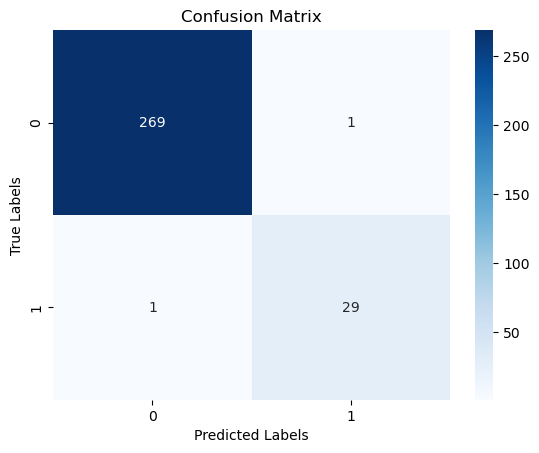

In [91]:
# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

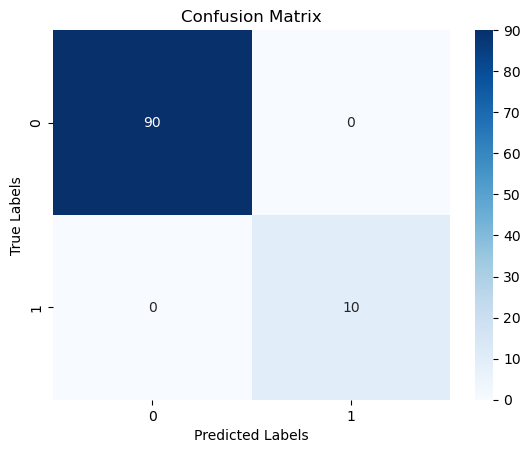

In [92]:
# Generate and display confusion matrix
cm = confusion_matrix(y_test2, y_pred2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

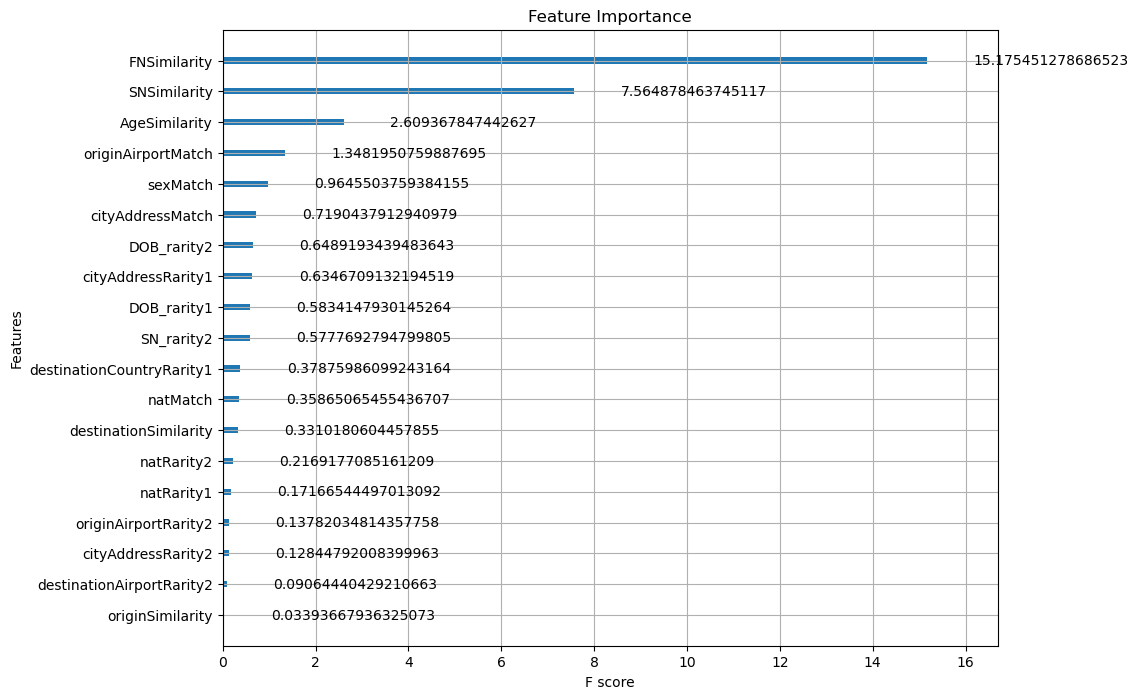

In [93]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model, ax=ax, importance_type='gain', show_values=True, title='Feature Importance')
plt.show()

In [95]:
cartesian_similarity_df['Mark'].unique()

<ArrowStringArray>
[        'Obs2-Obs2',         'Obs2-Obs3',     'Obs2-Original',
         'Obs2-Obs1',         'Obs3-Obs2',         'Obs3-Obs3',
     'Obs3-Original',         'Obs3-Obs1',     'Original-Obs2',
     'Original-Obs3', 'Original-Original',     'Original-Obs1',
         'Obs1-Obs2',         'Obs1-Obs3',     'Obs1-Original',
         'Obs1-Obs1']
Length: 16, dtype: string

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       270
           1       0.97      0.97      0.97        30

    accuracy                           0.99       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300

ROC-AUC Score: 0.9988888888888889
Precision-Recall AUC: 0.9922064777327935


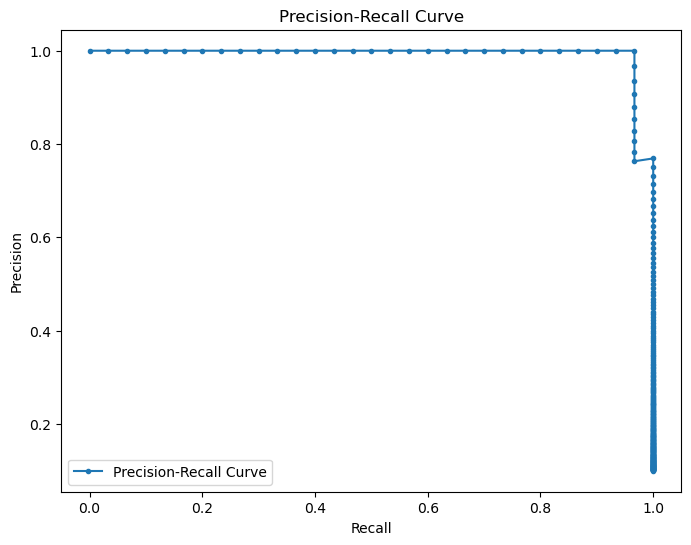

In [94]:
# Precision, Recall, F1-Score
print(classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc}")

# Precision-Recall Curve and AUC
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc}")

# Plotting Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()

# Inference Testing

In [7]:
# from similarity_search import perform_similarity_search, find_similar_passengers, parse_xml
# from loc_access import LocDataAccess

from fuzzywuzzy import fuzz
import xml.etree.ElementTree as ET
import os
import glob
import pandas as pd
import string
import joblib


# airport_data_access = LocDataAccess.get_instance()
airport_data_access = LocDataAccess.get_instance()  # Access the singleton instance
firstname = 'Jamie'
surname = 'Smooth'
name = firstname + ' ' + surname
iata_o = 'DXB'
iata_d = 'AMS' 
dob = '1974-05-22'
city_name = 'DUBAI'
nationality = 'PYF'
sex = 'M'
address = '41658 Mckinney Ridges Apartment no. 270 Shawmouth, Wyoming 27446'

nameThreshold = 60
ageThreshold = 60 
locationThreshold = 90


all_data = pd.read_csv('parsed_xml.csv')

lon_o, lat_o = airport_data_access.get_airport_lon_lat_by_iata(iata_o)
lon_d, lat_d = airport_data_access.get_airport_lon_lat_by_iata(iata_d)
lon_c, lat_c = airport_data_access.get_airport_lon_lat_by_city(city_name)
country = airport_data_access.get_country_by_city(city_name)
ctry_org = airport_data_access.get_country_by_airport_iata(iata_o)
ctry_dest = airport_data_access.get_country_by_airport_iata(iata_d)
city_org = airport_data_access.get_city_by_airport_iata(iata_o)
city_dest = airport_data_access.get_city_by_airport_iata(iata_d)
# result = perform_similarity_search(firstname, surname, name, iata_o, lat_o, lon_o, city_org, ctry_org, iata_d, lat_d, lon_d, city_dest, ctry_dest, dob, city_name, lat_c, lon_c, country, nationality, sex, address, df, nameThreshold, ageThreshold, locationThreshold)
# print(type(result))  # Should show <class 'tuple'>
# print(len(result))  # Should show 4
filtered_result_df, result_df = perform_similarity_search(firstname, surname, name, iata_o, lat_o, lon_o, city_org, ctry_org, iata_d, lat_d, lon_d, city_dest, ctry_dest, dob, city_name, lat_c, lon_c, country,  nationality, sex, address, all_data, nameThreshold, ageThreshold, locationThreshold)

In [8]:
pred_only = result_df[result_df['predictions_x'] == 1]
pred_only[['FNSimilarity', 'SNSimilarity', 'DOBSimilarity', 'AgeSimilarity', 'strAddressSimilarity', 'jcdAddressSimilarity', 'Address', 'originSimilarity', 'originExpScore', 'OriginLon', 'OriginLat']]

,FNSimilarity,SNSimilarity,DOBSimilarity,AgeSimilarity,strAddressSimilarity,jcdAddressSimilarity,Address,originSimilarity,originExpScore,OriginLon,OriginLat
6182,80,73,90,90.0,86.0,0.565217,"41658 Mckinney Ridges Apt. 270\nShawmouth, WY ...",100.0,1.0,55.364399,25.2528


In [9]:
filtered_result_df

,unique_id,Unnamed: 0,FilePath,BookingID,Firstname,Surname,Name,Travel Doc Number,Place of Issue,OriginIATA,...,destinationCountryMatch,destinationCountryRarity1,destinationCountryProb1,destinationCountryRarity2,destinationCountryProb2,originSimilarity,originExpScore,destinationSimilarity,destinationExpScore,predictions_y
6182,6182,6182,XMLs/flight_id_178543.xml,DXB-AMS-leisure-ID1138,Jaime,Smith,Jaime Smith,PYF_9217_1,PYF,DXB,...,1,0.081978,0.001563,0.081978,0.001563,100.0,1.0,100.0,1.0,1
